### Максим Смирнов @SupremumOfTilt
# Фрактальное сжатие



## Немного теории
Алгоритм описан в главе про [сжатие изображений](https://compression.ru/book/part2/part2__3.htm#_Toc448152512).

### Определения
**Ранговый блок**: если исходное изображение разбивается на непересекающиеся блоки одинакового размера, замощающие всё изображение, то каждый такой блок называется *ранговым*; имеют меньший размер, чем доменные блоки.

**Доменный блок**: если исходное изображение разбивается блоки одинакового размера, которые могут и пересекаться, то каждый такой блок называется *доменным*; имеют больший размер, чем ранговые блоки.

**Идея алгоритма**:

При сжатии:
1. для каждого рангового блока найти наиболее похожий на него доменный блок (с учётом поворотов и симметрии)
2. выполнить преобразование яркости
3. в качестве сжатого изображения выступают коэффициенты преобразования ранговых блоков, эффективно записанные в файл (строку)

При декомпрессии:
1. Прочитать файл (строку), извлечь коэффициенты преобразований
2. Применить преобразования к исходному изображению (обычно просто серое) пока результат не стабилизируется

In [24]:
import os
import itertools
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np

from skimage import io
from skimage import data, img_as_float64
from skimage.metrics import mean_squared_error as mse, peak_signal_noise_ratio as psnr
from skimage.transform import resize
from skimage.color import rgb2gray, rgb2yuv, yuv2rgb

from tqdm import tqdm

In [26]:
lenna_rgb_512x512 = io.imread('lenna.bmp')
lenna_rgb_256x256 = resize(lenna_rgb_512x512, (256, 256))
lenna_gray_256x256 = np.rint(rgb2gray(lenna_rgb_256x256) * 255).astype('uint8')

In [27]:
BlockTransform = namedtuple('BlockTransform', ['x', 'y', 'di', 'tr'])
FractalCompressionParams = namedtuple(
    'FractalCompressionParams', [
        'height',
        'width',
        'is_colored',
        'block_size',
        'spatial_scale',
        'intensity_scale',
        'stride',
        'mode'
    ]
)

In [28]:
def derive_num_bits(length, stride): 
    return np.ceil(np.log2(length / stride)).astype(int) 


In [6]:
def is_colored(image):
    if len(image.shape) == 2:
        return False
    elif len(image.shape) == 3 and image.shape[-1] == 3:
        return True
    else:
        message = 'Invalid shape of the image: `{}`'
        raise ValueError(message.format(image.shape))

### [4 балла] Функция для нахождения наилучшего преобразования рангового блока

#### Описание

на входе функции подаются:
* исходное Ч/Б изображение (`image`)
* уменьшенное изображение (`resized_image`)
* координаты рангового блока (`x`, `y`)
* размер блока (`block_size`)
* шаг, через сколько пикселей перескакивать при переборе (`stride`)

на выходе функция должна выдавать:
* лучшее преобразование в смысле MSE, объект типа `BlockTransform`

In [ ]:
BlockTransform = namedtuple('BlockTransform', ['x', 'y', 'di', 'tr'])
FractalCompressionParams = namedtuple(
    'FractalCompressionParams', [
        'height',
        'width',
        'is_colored',
        'block_size',
        'spatial_scale',
        'intensity_scale',
        'stride',
        'mode'
    ]
)
def find_block_transform(image, resized_array, x, y, block_size, stride,domain_array,deviation_array, sum_field_domain_array,dom_sq):
    '''
    Find best transformation for given rank block.
    
    Parameters
    ----------
    image : np.array
        Source B/W image.

    resized_image: np.array
        Resized source image.

    x, y: int, int
        Coordinates of the rank block.
    
    block_size: int
        Size of rank block.

    stride: int
        Vertical and horizontal stride for domain block search.

    Returns
    -------
    best_transform: BlockTransform
        Best transformation.
    '''
    
    coeff_of_resize = resized_array[0].shape[0] / image.shape[0]
    stride_0 = stride
    stride = (int)(stride * coeff_of_resize)
 
    rank_field = image[x:x+block_size,y:y+block_size]
    
    sum_field_rank = np.sum(rank_field)
    rank_qv = np.sum(rank_field ** 2)
    min_distance = float('inf')
            
    for i in np.arange(len(domain_array)):
        
        field = domain_array[i]
        
        deviation = deviation_array[i] 
        sum_field_domain = sum_field_domain_array[i] 
        sum_mul = np.sum(rank_field*field)
        dom_qv = dom_sq[i]
        
        if (deviation == 0):
            contrast_current = 0
        else:
            contrast_current = (field.size*sum_mul- sum_field_rank*sum_field_domain)/deviation
       
        if (contrast_current > 1):
            contrast_current = 1
        else:
            if (contrast_current < 0):
                contrast_current = 0
        
        temp = contrast_current * field
        sum_temp = contrast_current * sum_field_domain
        brightness_current = (sum_field_rank - sum_temp) / field.size
        
        new_field = temp + brightness_current

        current_distance = dom_qv * (contrast_current) ** 2 + field.size * brightness_current ** 2 + 
                        rank_qv - 2 * contrast_current * sum_mul + 2 * contrast_current * brightness_current * sum_field_domain -
                        2 * brightness_current * sum_field_rank 
       
        if ((current_distance < min_distance)):
            min_distance = current_distance
            brightness_current = np.around(brightness_current)
            best_transformation = [i, contrast_current, brightness_current]
            
            
    num = best_transformation[0] % 8
    best_transformation[0] = best_transformation[0] // 8
    
    resized_domain_x = best_transformation[0] // ((resized_array.shape[0]-block_size) // stride + 1)
    resized_domain_y = best_transformation[0] - ((resized_array.shape[1] - block_size) // stride + 1) * resized_domain_x
    
    best_transformation = [resized_domain_x, resized_domain_y, num, best_transformation[1], best_transformation[2]]
  
    return best_transformation

### [4 балла] Применение IFS к изображению

#### Описание

на входе функции подаются:
* исходное изображение (`image`)
* уменьшенное изображение (`resized_image`)
* IFS, массив объектов типа `BlockTransform` (`transforms`)
* размер блока (`block_size`)

на выходе функция должна выдавать:
* картинку после одинарного применения IFS

In [77]:
def perform_transform(image, resized_image, transforms, block_size, stride=1, comp=0):
    '''
    Perform IFS on given image.
    
    Parameters
    ----------
    image : np.array
        Source image.

    resized_image: np.array
        Resized source image.

    transforms: list of BlockTransform's
        Given IFS, Iterated Function System
    
    block_size: int
        Size of rank block.

    Returns
    -------
    transformed_image: np.array
        Transformed image.
    '''
    def rotator(field, angle):
        return np.rot90(field, angle/np.pi*2)
   
    def contrast_changer(field, contrast):
        return field * contrast
    
    def reflector(field, reflect_status):
        return field[::reflect_status,]
    
    def brightness_changer(field, brightness):
        return field + brightness
    
    def affine_transformator(field, angle, reflect_status, contrast, brightness):
        new_field = reflector(field, reflect_status)
        new_field = rotator(new_field, angle)
        
        new_field = contrast_changer(new_field, contrast)
        new_field = brightness_changer(new_field, brightness)
        return new_field
    
    coeff_of_resize = resized_image.shape[0] / image.shape[0]
    height = image.shape[0]
    width = height
    transformed_image = np.zeros((height, width))
    i = j = 0
    stride = stride // 2
    

    for k in np.arange(len(transforms)):

        resized_domain_x, resized_domain_y, tr, contrast_current, brightness_current = transforms[k]
        resized_domain_x *= stride
        resized_domain_y *= stride

        angle_current=(tr%4)*np.pi / 2
        if (tr >= 4):
            reflector_current =- 1
        else: 
            reflector_current = 1
        if (brightness_current >= 256):

            brightness_current = brightness_current - 512

        current_block = resized_image[resized_domain_x:resized_domain_x + block_size, resized_domain_y:resized_domain_y + block_size]

        current_transform = affine_transformator(current_block, angle_current, reflector_current, contrast_current, brightness_current)

        transformed_image[i * block_size:(i + 1) * block_size, j * block_size:(j + 1)*block_size] = current_transform
        j += 1
        if (j == (width / block_size)):
            i += 1
            j=0


    return transformed_image

### [7 баллов] Класс, реализующий интерфейс битового массива
Он понадобится для преобразования найденной IFS в строку, чтобы записать сжатый файл на диск.

In [ ]:
class BitBuffer:
    '''Class that provides storing and and reading integer numbers 
    in continuous bytearray.

    Parameters
    ----------
    buffer : bytearray, optional (default=None)
        Input bytearray, for initialization.

    Attributes
    ----------
    _buffer : bytearray
        Bytearray that can contain any information.

    Examples
    --------
    >>> buffer = BitBuffer()
    >>> buffer.push(1, 1)
    >>> x = buffer.pop(1)
    >>> print(x)
    1
    >>> buffer.push(125, 18)
    >>> x = buffer.pop(18)
    >>> print(x)
    125
    >>> buffer.push(5, 3)
    >>> x = buffer.pop(3)
    >>> print(x)
    5

    >>> dy = transform.y // stride
    >>> buffer.push(dy, self._num_bits_ver)
    '''

    def __init__(self, buffer=None):
        self._buffer = buffer or bytearray()
        self._size = 0
        self._start = 0
        self._value = 0
        self._space = 8

    def to_bytearray(self):
        '''Convert to bytearray.
    
        Returns
        -------
        buffer: bytearray
            Bytearray that contains all data.
        '''

        return self._buffer

    def push(self, x, n_bits):
        '''Push given integer to buffer.
    
        Parameters
        ----------
        x : int
            Input number.

        n_bits: int
            Number of bits for store input number,
            should be greater than log2(x).
        '''
        while (n_bits > 0):
            temp_bit = x % 2
            x = x // 2
            if (temp_bit):
                self._value |= (1 << (self._space - 1))
               
            self._space -= 1
            n_bits -= 1
            if (self._space == 0):
                self._buffer.append(self._value);
                self._value = 0
                self._space = 8
                
    def pop(self, n_bits):
        
        '''
        Pop n_bits from buffer and transform it to a number.
    
        Parameters
        ----------
        n_bits: int
            Number of bits for pop from buffer.

        Returns
        -------
        x: int
            Extracted number.
        '''
        x=0
        pos=0
        temp_byte = self._buffer[self._start // 8];
        temp_byte <<= (self._start % 8)
        while (n_bits > 0):
            temp_bit = temp_byte & 128
            temp_bit >>= 7
            
            temp_byte <<= 1
            if (temp_bit):
                x |= (1 << pos)

            n_bits -= 1
            self._start += 1
            pos += 1
            
            if (self._start % 8 == 0 and n_bits > 0):
                temp_byte = self._buffer[self._start // 8];
                
                
        return x
    def finish(self):
        self._buffer.append(self._value)



In [80]:
# GRADED CELL: FractalCompressor

class FractalCompressor:
    '''Class that performs fractal compression/decompression of images.

    Attributes
    --------
    _num_bits_ver : int
        Number of bits for store VERTICAL OFFSET for each transformation.
    
    _num_bits_hor : int
        Number of bits for store HORIZONTAL OFFSET for each transformation.
        
    _num_bits_pix : int
        Number of bits for store INTENSITY OFFSET for each transformation.
        
    _num_bits_tfm : int
        Number of bits for store TRANFORMATION INDEX for each transformation.

    Examples
    --------
    >>> comp = FractalCompressor()
    >>> compressed_image = comp.compress(image, block_size=8, stride=2)
    >>> decompressed_image = comp.decompress(compressed_image, num_iters=9)
    >>> yet_another_compressed_image = comp.compress(image, 8, 4, 0.5, 0.7)
    >>> yet_another_decompressed_image = comp.compress(yet_another_compressed_image, 5)
    '''

    def __init__(self):
        self._num_bits_ver = None
        self._num_bits_hor = None
        self._num_bits_pix = 9
        self._num_bits_tfm = 3
        self._num_bits_height = None
        self._num_bits_width = None
        self._num_bits_is_colored = None
        self._num_bits_block_size = None
        self._num_bits_spatial_scale = None
        self._num_bits_intensity_scale = 7
        self._num_bits_stride = None
        self._num_bits_mode = 1
            
    def _add_header(self, buffer, params):
        '''Store header in buffer.
    
        Parameters
        ----------
        buffer: BitBuffer
            
        params: FractalCompressionParams
            Parameters that should be stored in buffer.

        Note
        ----
        This method must be consistent with `_read_header`.
        '''
     
        self._num_bits_height = derive_num_bits(params.height, 1) + 1

        self._num_bits_width = derive_num_bits(params.width, 1) + 1

        self._num_bits_is_colored = 1
        
        self._num_bits_block_size = derive_num_bits(params.block_size, 1) + 1
     
        self._num_bits_spatial_scale = derive_num_bits(10 * params.spatial_scale, 1)
  
        
        
        self._num_bits_stride = derive_num_bits(params.stride, 1) + 1
     
        
        buffer.push(params.height, self._num_bits_height)
       
        buffer.push(params.width, self._num_bits_width)
        
        buffer.push(params.is_colored, self._num_bits_is_colored)
    
        buffer.push(params.block_size, self._num_bits_block_size)
      
        buffer.push(10 * params.spatial_scale, self._num_bits_spatial_scale)
        
        translated_intens = params.intensity_scale * 127
        
        buffer.push(translated_intens, self._num_bits_intensity_scale)
        
        buffer.push(params.stride, self._num_bits_stride)  
     
        buffer.push(params.mode, self._num_bits_mode)
        
    def _read_header(self, buffer):
        '''Read header from buffer.
    
        Parameters
        ----------
        buffer: BitiBuffer

        Returns
        -------
        params: FractalCompressionParams
            Extracted parameters.
            
        Note
        ----
        This method must be consistent with `_add_header`.
        '''
        
        height = buffer.pop(self._num_bits_height)
        width = buffer.pop(self._num_bits_width)
        is_colored = buffer.pop(self._num_bits_is_colored)
        block_size = buffer.pop(self._num_bits_block_size)
        spatial_scale = buffer.pop(self._num_bits_spatial_scale) / 10.0
        
        intensity_scale = buffer.pop(self._num_bits_intensity_scale) / 127.0
        stride = buffer.pop(self._num_bits_stride)
        mode = buffer.pop(self._num_bits_mode)
        params = FractalCompressionParams(height, width, is_colored, block_size, spatial_scale, intensity_scale, stride, mode)
        return params
    
    def _add_to_buffer(self, buffer, transform, stride):
        '''Store block transformation in buffer.
    
        Parameters
        ----------
        buffer: BitBuffer

        transform: BlockTransform
            
        stride: int
            Vertical and horizontal stride for domain block search.

        Note
        ----
        This method must be consistent with `_read_transform`.
        '''
        
        buffer.push(transform[0], self._num_bits_ver)
        buffer.push(transform[1], self._num_bits_hor)
        buffer.push(transform[2], self._num_bits_tfm)
        translated_intens = np.around(127 * transform[3])
        buffer.push(translated_intens, self._num_bits_intensity_scale)
        buffer.push(transform[4], self._num_bits_pix)
                    
                    
                    
    def _read_transform(self, buffer, stride):
        '''Read block transformation from buffer.
    
        Parameters
        ----------
        buffer: BitBuffer

            
        stride: int
            Vertical and horizontal stride for domain block search.
            
        Returns
        -------
        transform: BlockTransform
            Extracted block transformation.

        Note
        ----
        This method must be consistent with `_add_to_buffer`.
        '''
        transform=list()
        transform.append(buffer.pop(self._num_bits_ver))
        transform.append(buffer.pop(self._num_bits_hor))
        transform.append(buffer.pop(self._num_bits_tfm))
        translated_intens = buffer.pop(self._num_bits_intensity_scale) / 127.0
        transform.append(translated_intens)
        transform.append(buffer.pop(self._num_bits_pix))


        return transform
    
    def _ifs2buf(self, params, transformations):
        '''Store compression parameters and IFS in buffer.
    
        Parameters
        ----------
        params: FractalCompressionParams
            Parameters of the compression.

        transformations: list of BlockTransform's
            Given IFS.

        Returns
        -------
        buffer: BitBuffer

        Note
        ----
        This method must be consistent with `_buf2ifs`.
        '''

        buffer = BitBuffer()
        
        self._num_bits_ver = derive_num_bits(params.height, params.stride)
        self._num_bits_hor = derive_num_bits(params.width, params.stride)
      
        self._add_header(buffer, params)
        
        for t in transformations:
            self._add_to_buffer(buffer, t, params.stride)
        buffer.finish()
        return buffer
    
    def _buf2ifs(self, buffer):
        '''Store compression parameters and IFS in buffer.
    
        Parameters
        ----------
        buffer: BitBuffer

        Returns
        -------
        params: FractalCompressionParams
            Extracted compression parameters.

        transforms: list of BlockTransform's
            Extracted IFS.

        Note
        ----
        This method must be consistent with `_ifs2buf`.
        '''
        params = self._read_header(buffer)
        self._num_bits_ver = derive_num_bits(params.height, params.stride)
        self._num_bits_hor = derive_num_bits(params.width, params.stride)
        num_transforms = int((params.height) * (params.width) / params.block_size ** 2)
        if (params.mode == 1):
            k = 1.5
        else:
            k = 3
        if (params.is_colored):
            num_transforms *= k
   
        transforms = [
            self._read_transform(buffer, params.stride)
            for _ in range(int(num_transforms))
        ]
        
        return params, transforms
        
        
    def compress(self, image, block_size=8, stride=1,
                 spatial_scale=0.5, intensity_scale=1, mode=1):
        '''Compress input image
        
        Parameters
        ----------
        image : np.array
            Source image.

        block_size: int, optional (default=8)
            Size of rank block.

        stride: int, optional (default=1)
            Vertical and horizontal stride for domain block search.
        
        spatial_scale : float, optional (default=0.5)
            ({rank block size} / {domain block size}) ratio, must be <1.
        
        intensity_scale : float, optional (default=0.75)
            Reduce coefficient for image intensity.

        Returns
        -------
        byte_array: bytearray
            Compressed image.
            
        Note
        ----
        This method must be consistent with `decompress`.
        '''
        
        #уменьшаем изображение (область доменных блоков) (resize порой странно себя вела)
        def reduce(img, factor):
            result = np.zeros((img.shape[0] // factor, img.shape[1] // factor))
            for i in range(result.shape[0]):
                for j in range(result.shape[1]):
                    result[i,j] = np.mean(img[i * factor:(i + 1) * factor, j * factor:(j + 1) * factor])
            return result
        #подсчет знаменателя в формуле для контрастности
        def deviation_calculator(field_domain):
      
            sum_field_qv = np.sum(field_domain ** 2)
      
            deviation = sum_field_qv * field_domain.size - np.sum(field_domain) ** 2
      
            return deviation, sum_field_qv
        
        
        is_col = is_colored(image)
        if (is_col):
            
            is_col = 1
        else:
            is_col = 0
        
        if (is_col):
            shape = (256, 256, 1)
            image = np.rint(255 * image).astype('uint8')
            new_image_0 = 0.299 * image[:,:,0] + 0.587 * image[:,:,1] + 0.114 * image[:,:,2]
            new_image_1 = -0.147 * image[:,:,0] - 0.289 * image[:,:,1] + 0.436 * image[:,:,2]
            new_image_2 = 0.877 * (image[:,:,0] - new_image_0)
            image = np.concatenate((np.reshape(new_image_0, shape), np.reshape(new_image_1, shape),np.reshape(new_image_2, shape)), axis = 2)
            
        source_image = image.astype('float64')
    
        new_width=int(image.shape[1] * spatial_scale)
        new_height=int(image.shape[0] * spatial_scale)
            
        shape = (new_height, new_width, 1)
  
      
        if (is_col):
            resized_image_0 = reduce(source_image[:,:,0],int(1 / spatial_scale))
    
            resized_image_1 = reduce(source_image[:,:,1],int(1 / spatial_scale))
        
            resized_image_2 = reduce(source_image[:,:,2],int(1 / spatial_scale))
        
            resized_image = np.concatenate((np.reshape(resized_image_0, shape), np.reshape(resized_image_1, shape),np.reshape(resized_image_2, shape)), axis = 2)
        else:
            resized_image = reduce(image,int(1 / spatial_scale))
        
        
        angle_list = np.arange(4)
        reflect_status = np.array([1,-1])
        
    
                        
        params = FractalCompressionParams(image.shape[0], image.shape[1], is_col, block_size, spatial_scale, intensity_scale, stride, mode)
        
        stride_temp = stride // 2
        transformations = []
        
        if (is_col):
            
            domain_0 = []
            domain_1 = []
            domain_2 = []
            deviation_array_0 = []
            deviation_array_1 = []
            deviation_array_2 = []
            dom_sq_0 = []
            dom_sq_1 = []
            dom_sq_2 = []
            sum_field_domain_array_0 = []
            sum_field_domain_array_1 = []
            sum_field_domain_array_2 = []
            
            
            
            for i in np.arange(0, resized_image.shape[0] - block_size + 1, stride_temp):
                for j in np.arange(0, resized_image.shape[1] - block_size + 1, stride_temp):
                    for reflector_current in reflect_status:
                        for angle_current in angle_list:
                            temp = resized_image[i:i + block_size, j:j + block_size, 0]
                            temp = temp[::reflector_current,]
                            current_block = np.rot90(temp, angle_current)
                            domain_0.append(current_block)
                            dev, dom_qv = deviation_calculator(current_block)
                            deviation_array_0.append(dev)
                            dom_sq_0.append(dom_qv)
                            sum_field_domain_array_0.append(np.sum(current_block))
            
            if (mode == 1):  #mode==1: немного хуже качество, в 2 раза лучше сжатие (перескакиваем через четные столбцы в 2 и 3 компонентах)
                block_size_chrome = 2 * block_size
            else:
                block_size_chrome = block_size
            
            for i in np.arange(0, resized_image.shape[0] - block_size_chrome + 1, stride_temp):
                for j in np.arange(0, resized_image.shape[1] - block_size_chrome + 1, stride_temp):
                    for reflector_current in reflect_status:
                        for angle_current in angle_list:
                            temp=resized_image[i:i + block_size_chrome, j:j + block_size_chrome, 1]
                            temp=temp[::reflector_current,]
                            current_block=np.rot90(temp, angle_current)
                            domain_1.append(current_block)
                            dev, dom_qv = deviation_calculator(current_block)
                            deviation_array_1.append(dev)
                            dom_sq_1.append(dom_qv)
                            sum_field_domain_array_1.append(np.sum(current_block))

            for i in np.arange(0, resized_image.shape[0] - block_size_chrome + 1, stride_temp):
                for j in np.arange(0, resized_image.shape[1] - block_size_chrome + 1, stride_temp):
                    for reflector_current in reflect_status:
                        for angle_current in angle_list:
                            temp = resized_image[i:i + block_size_chrome,j:j + block_size_chrome, 2]
                            temp = temp[::reflector_current,]
                            current_block = np.rot90(temp,angle_current)
                            domain_2.append(current_block)
                            dev,dom_qv = deviation_calculator(current_block)
                            deviation_array_2.append(dev)
                            dom_sq_2.append(dom_qv)
                            sum_field_domain_array_2.append(np.sum(current_block))
                        
                        
                        
            xs_0 = [x for x in np.arange(0, image.shape[1], block_size)]  
            ys_0 = [y for y in np.arange(0, image.shape[0], block_size)]  
            xs_1_2 = [x for x in np.arange(0, image.shape[1], block_size_chrome)]  
            ys_1_2 = [y for y in np.arange(0, image.shape[0], block_size_chrome)] 
            
            
                
            for x, y in tqdm(itertools.product(xs_0, ys_0), total = len(xs_0) * len(ys_0)):
                transform = find_block_transform(
                    source_image[:,:,0], resized_image,
                    x, y, block_size, stride,domain_0, deviation_array_0, sum_field_domain_array_0, dom_sq_0
                )
                transformations.append(transform)
            for x, y in tqdm(itertools.product(xs_1_2, xs_1_2), total = len(xs_1_2) * len(xs_1_2)):
                transform = find_block_transform(
                   source_image[:,:,1], resized_image,
                    x, y, block_size_chrome, stride, domain_1, deviation_array_1, sum_field_domain_array_1, dom_sq_1
                )
                transformations.append(transform)
            for x, y in tqdm(itertools.product(xs_1_2, ys_1_2), total = len(xs_1_2) * len(xs_1_2)):
                transform = find_block_transform(
                    source_image[:,:,2], resized_image,
                    x, y, block_size_chrome, stride,domain_2, deviation_array_2, sum_field_domain_array_2, dom_sq_2
                )
                transformations.append(transform)
        else: 
            domain_array = []
            sum_field_domain_array = []
            deviation_array = []
            dom_sq = []
            for i in np.arange(0, resized_image.shape[0] - block_size + 1, stride_temp):
                for j in np.arange(0, resized_image.shape[1] - block_size + 1, stride_temp):
                    for reflector_current in reflect_status:
                        for angle_current in angle_list:
                            temp = resized_image[i:i + block_size,j:j + block_size]
                            temp = temp[::reflector_current,]
                            current_block = np.rot90(temp, angle_current)
                            domain_array.append(current_block)
                            dev,dom_qv = deviation_calculator(current_block)
                            deviation_array.append(dev)
                            dom_sq.append(dom_qv)
                            sum_field_domain_array.append(np.sum(current_block))
            
                
            xs=[x for x in np.arange(0, image.shape[0], block_size)]  
            ys=[y for y in np.arange(0, image.shape[1], block_size)]  
            for x, y in tqdm(itertools.product(xs, ys), total = len(xs) * len(ys)):
                transform = find_block_transform(
                    source_image, resized_image,
                    x, y, block_size, stride,domain_array, deviation_array, sum_field_domain_array, dom_sq
                )
               
            
                transformations.append(transform)
   
        buffer = self._ifs2buf(params, transformations)
        return buffer.to_bytearray()
            
    def compress2(self, image, quality=50):
        '''Compress input image
        
        Parameters
        ----------
        image : np.array
            Source image.

        quality: int, optional (default=50)
            Quality of image compression

        Returns
        -------
        byte_array: bytearray
            Compressed image.
            
        Note
        ----
        This method must be consistent with `decompress`.
        '''
         
        if (quality == 0):
            return self.compress(image, block_size=32, stride=2, mode=1)
        if (quality == 20):
            return self.compress(image, block_size=16, stride=4, mode=1)
        if (quality == 40):
            return self.compress(image, block_size=8, stride=16, mode=1)
        if (quality == 60):
            return self.compress(image, block_size=8, stride=8, mode=1)
        if (quality == 80):
            return self.compress(image, block_size=4, stride=16, mode=1)
        if (quality == 100):
            return self.compress(image, block_size=4, stride=16, mode=0)
        return self.compress(image)
    
    def decompress(self, byte_array, num_iters=10):
        '''Compress input image
        
        Parameters
        ----------
        byte_array: bytearray
            Compressed image.

        num_iters: int, optional (default=10)
            Number of iterations to perform IFS.

        Returns
        -------
        image: np.array
            Decompressed image.
            
        Note
        ----
        This method must be consistent with `compress`.
        '''
        def reduce(img, factor):
            result = np.zeros((img.shape[0] // factor, img.shape[1] // factor))
            for i in range(result.shape[0]):
                for j in range(result.shape[1]):
                    result[i,j] = np.mean(img[i*factor:(i+1) * factor,j*factor:(j+1) * factor])
            return result
         
        buffer = BitBuffer(byte_array)
        
        params,transformations = self._buf2ifs(buffer) 
        
        if (params.is_colored):          
            image_0 = np.random.randint(0, 1, (params.height, params.width))

            image_1 = np.random.randint(0, 1, (params.height, params.width))
            image_2 = np.random.randint(0, 1, (params.height, params.width))

            shape = (params.height,params.height, 1)
            image_t = np.concatenate((np.reshape(image_0, shape), np.reshape(image_1, shape),np.reshape(image_2, shape)), axis=2).astype('float64')
           
            new_width = int(params.height * params.spatial_scale)
            new_height = int(params.width * params.spatial_scale)

            
            shape_2 = (new_height,new_width, 1)
  

            resized_image_0 = reduce(image_t[:,:,0], int(1 / params.spatial_scale))
            resized_image_1 = reduce(image_t[:,:,1], int(1 / params.spatial_scale))
            resized_image_2 = reduce(image_t[:,:,2], int(1 / params.spatial_scale))
            resized_image_t = np.concatenate((np.reshape(resized_image_0, shape_2), np.reshape(resized_image_1, shape_2),np.reshape(resized_image_2, shape_2)), axis = 2)
            
            
            length = len(transformations)
            
            if (params.mode == 1):
                point_1 = 2 * length / 3
                point_2 = length / 6 + point_1
                block_size_chrome = 2 * params.block_size
            else:
                point_1 = length / 3
                point_2 = 2 * length / 3
                block_size_chrome = params.block_size
            for iters in range(num_iters):            
                image_0 = perform_transform(image_t[:,:,0], resized_image_t[:,:,0], transformations[0:int(point_1)], params.block_size, params.stride)
                image_1 = perform_transform(image_t[:,:,1], resized_image_t[:,:,1], transformations[int(point_1):int(point_2)], block_size_chrome, params.stride)
                image_2 = perform_transform(image_t[:,:,2], resized_image_t[:,:,2], transformations[int(point_2):length], block_size_chrome, params.stride)
              
               
                image = np.concatenate((np.reshape(image_0, shape), np.reshape(image_1, shape), np.reshape(image_2, shape)), axis = 2)
                
                new_image_0 = image[:,:,0] + 1.140 *image[:,:,2]
                new_image_1 = image[:,:,0] - 0.581 * image[:,:,2] - 0.395 * image[:,:,1] 
                new_image_2 = image[:,:,0] +2.032 * image[:,:,1] 
                
                new_image_0 = np.clip(new_image_0, 0, 255)
                new_image_1 = np.clip(new_image_1, 0, 255)
                new_image_2 = np.clip(new_image_2, 0, 255)
                
                
                image = np.concatenate((np.reshape(new_image_0, shape), np.reshape(new_image_1, shape), np.reshape(new_image_2, shape)), axis=2)
                image = np.rint(image).astype('uint8')
              
                image_t = np.concatenate((np.reshape(image_0, shape), np.reshape(image_1, shape), np.reshape(image_2, shape)), axis=2)
             
    
                resized_image_0 = reduce(image_t[:,:,0], int(1 / params.spatial_scale))
                resized_image_1 = reduce(image_t[:,:,1], int(1 / params.spatial_scale))
                resized_image_2 = reduce(image_t[:,:,2], int(1 / params.spatial_scale))
                resized_image_t = np.concatenate((np.reshape(resized_image_0, shape_2), np.reshape( resized_image_1, shape_2),np.reshape( resized_image_2, shape_2)), axis=2).astype('float64')
            
        else:
            image_t = np.random.randint(0, 1, (params.height, params.width))
           
            new_width = (image_t.shape[1]) * params.spatial_scale
            new_hight = (image_t.shape[0]) * params.spatial_scale

            resized_image = reduce(image_t, int(1 / params.spatial_scale))
   
            for iters in range(num_iters):            
                image_t = perform_transform(image_t, resized_image, transformations, params.block_size, params.stride, comp=0)
                new_image = image_t
                resized_image = reduce(image_t, int(1 / params.spatial_scale))
                new_image = np.clip(new_image, 0, 255)
                image = np.rint(new_image).astype('uint8')

        return image

## Пробуем применить FractalCompressor

In [72]:
comp = FractalCompressor()

In [12]:
result_16x4 = comp.compress(lenna_rgb_256x256 , block_size=16, stride=16,mode=0)

100%|██████████| 256/256 [00:08<00:00, 30.31it/s]


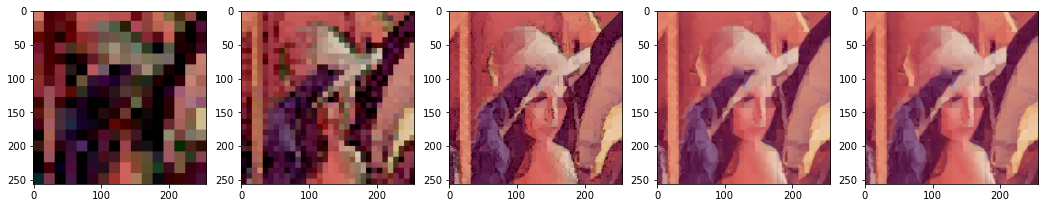

In [13]:
n_iters = [1,2,4,8,12]

imgs = [comp.decompress(result_16x4, n) for n in n_iters]
_, axs = plt.subplots(ncols=len(imgs), figsize=(18, 6))
for index in range(len(imgs)):
    axs[index].imshow(np.rint(imgs[index]).astype('uint8'),cmap='gray')
    
plt.show()


In [14]:
result_16x2 = comp.compress(lenna_gray_256x256, block_size=16, stride=4)

100%|██████████| 256/256 [00:31<00:00,  8.18it/s]


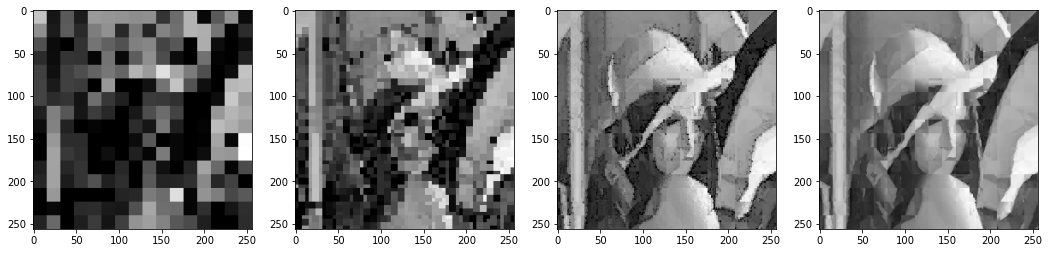

In [15]:
n_iters = [1, 2, 4, 8]

imgs = [comp.decompress(result_16x2, n) for n in n_iters]
_, axs = plt.subplots(ncols=len(imgs), figsize=(18, 6))
for index in range(len(imgs)):
    axs[index].imshow(imgs[index], cmap='gray')

plt.show()

In [64]:
result_8x4 = comp.compress(lenna_gray_256x256, block_size=4, stride=16)

100%|██████████| 4096/4096 [02:16<00:00, 30.08it/s]


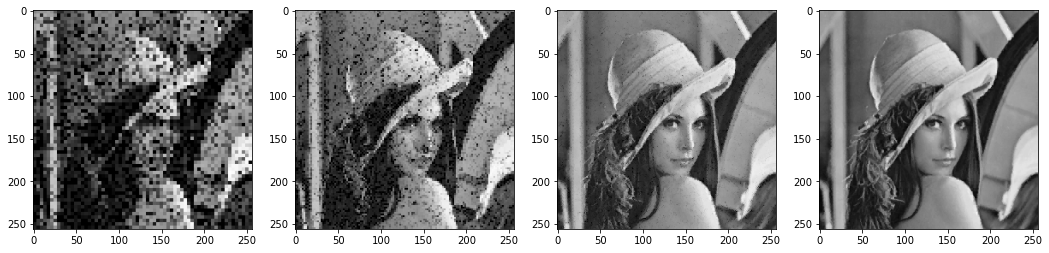

In [65]:
n_iters = [1, 2, 4, 8]

imgs = [comp.decompress(result_8x4, n) for n in n_iters]
_, axs = plt.subplots(ncols=len(imgs), figsize=(18, 6))
for index in range(len(imgs)):
    axs[index].imshow(imgs[index], cmap='gray')

plt.show()

In [74]:
result_8x4_rgb = comp.compress(lenna_rgb_256x256, block_size=4, stride=16)

100%|██████████| 1024/1024 [00:33<00:00, 30.41it/s]


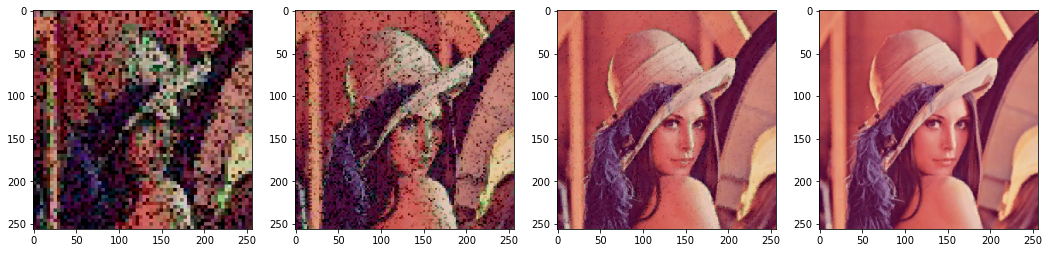

In [78]:
n_iters = [1, 2, 4, 8]

imgs = [comp.decompress(result_8x4_rgb, n) for n in n_iters]
_, axs = plt.subplots(ncols=len(imgs), figsize=(18, 6))
for index in range(len(imgs)):
    axs[index].imshow(imgs[index], cmap='gray')

plt.show()

## Построим график качества
Качество в данном случае будет измеряться по PSNR (а значит в децибелах).

Это базовый график для понимания соотношения между коэффициентом сжатия и качеством, получаемым на выходе. Можно посмотреть, как он будет меняться в зависимости от количества итераций при декомпрессии, например.

In [16]:
def weighted_psnr(ref, img):
    assert ref.shape == img.shape, "Shape mismatch"
    if is_colored(img):
        ref_yuv = rgb2yuv(ref)
        img_yuv = rgb2yuv(img)
        
        return (4 * psnr(ref_yuv[..., 0], img_yuv[..., 0]) +
                    psnr(ref_yuv[..., 1], img_yuv[..., 1]) +
                    psnr(ref_yuv[..., 2], img_yuv[..., 2])
               ) / 6
    else:
        return psnr(ref, img)

In [60]:
quality = [0, 20 , 40, 60, 80, 100]

def test_image(img):
    compressed_images = []
    n = 0
    fractal = []
    for q in quality:
        fractal.append(FractalCompressor())
        compressed_images.append(fractal[n].compress2(img, quality=q))
        n += 1
    decompressed_images = []
    n = 0
    for compressed in compressed_images:     
        decompressed_images.append(fractal[n].decompress(compressed))
        n += 1
    compression_rates = np.array([len(compressed) for compressed in compressed_images]) / img.size
    psnrs = [weighted_psnr(img, decompressed) for decompressed in decompressed_images]
    return compression_rates, psnrs

In [61]:
def test_and_plot_collection(collection):
    _, ax = plt.subplots(figsize=(8, 6))

    for image in collection:
        compression_rates, psnrs = test_image(image)
        ax.plot(compression_rates, psnrs, marker='o', ms=10, ls='-.')

    ax.set_xlabel('Compression Rate', fontsize=16)
    ax.set_ylabel('PSNR, dB', fontsize=16)

    plt.show()

100%|██████████| 4096/4096 [02:26<00:00, 28.04it/s]


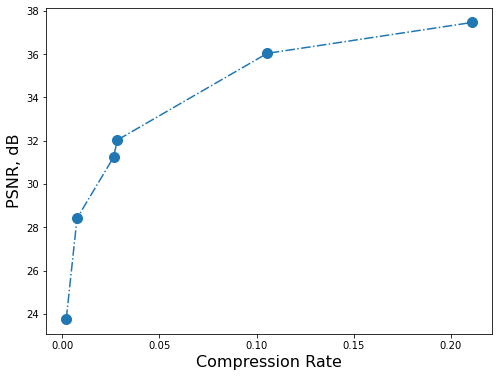

In [62]:
test_and_plot_collection([lenna_rgb_256x256])

In [63]:
"""""""""
collection = []
for image_name in os.listdir('test_files'):
    image = resize(io.imread(os.path.join('test_files', image_name)), (256, 256))
    if is_colored(image):
        image = np.rint(rgb2gray(image) * 255).astype('uint8')
    collection.append(image)
test_and_plot_collection(collection)
"""""""""
None

### Использование квадродерева (TODO: работает корректно, но слишком долго) 

In [75]:
def find_block_transform_quad(image, resized_image, x, y, block_size, stride,domain_array, deviation_array, sum_field_domain_array ,dom_sq, quad_depth=0, threshold=10000):

    def deviation_calculator(field_domain):
      
        sum_field_qv = np.sum(field_domain ** 2)

        deviation = sum_field_qv * field_domain.size - np.sum(field_domain) ** 2

        return deviation, sum_field_qv
        
    
    best_transformation = []
    
    quad_flag = False
    coeff_of_resize = resized_image[0].shape[0] / image.shape[0]
    stride_0 = stride
    stride=(int)(stride * coeff_of_resize)
 
    rank_field = image[x:x + block_size,y:y + block_size]
    
    sum_field_rank = np.sum(rank_field)
    rank_qv = np.sum(rank_field ** 2)
    min_distance = float('inf')
    angle_list = np.arange(4)
    reflect_status = np.array([1,-1])
            
    for i in np.arange(len(domain_array)):
        
        field = domain_array[i]
        
        deviation = deviation_array[i] 
        sum_field_domain = sum_field_domain_array[i] 
        sum_mul = np.sum(rank_field * field)
        dom_qv = dom_sq[i]
        
        if (deviation == 0):
            contrast_current = 0
        else:
            contrast_current = (field.size * sum_mul - sum_field_rank * sum_field_domain) / deviation
       
        if (contrast_current > 1):
            contrast_current = 1
        else:
            if (contrast_current < 0):
                contrast_current = 0
        
        temp = contrast_current * field
        sum_temp = contrast_current * sum_field_domain
        brightness_current = (sum_field_rank-sum_temp) / field.size
        
        new_field = temp + brightness_current

        current_distance = dom_qv * (contrast_current) ** 2 + field.size * brightness_current ** 2 + rank_qv - 2 * contrast_current * sum_mul + 2 * contrast_current * brightness_current * sum_field_domain - 2 * brightness_current * sum_field_rank
        
        
        if ((current_distance < min_distance and block_size == 4) or (current_distance < threshold)):
            quad_flag = True
            min_im = new_field
            min_distance = current_distance
            brightness_current = np.around(brightness_current)
            best_transformation = [quad_depth,i,contrast_current, brightness_current]
            num = best_transformation[1] % 8
            best_transformation[1] = best_transformation[1] // 8
    
            resized_domain_x = best_transformation[1] // ((resized_image.shape[0] - block_size) // stride + 1)
            resized_domain_y = best_transformation[1] - ((resized_image.shape[1] - block_size) // stride + 1) * resized_domain_x
    
            best_transformation = [quad_depth, resized_domain_x, resized_domain_y, num, best_transformation[2], best_transformation[3]]
            if (block_size != 4):
                break
                    
    if (quad_flag==False):
        domain_array=[]
        sum_field_domain_array=[]
        deviation_array=[]
        dom_sq=[]
        block_size=block_size//2
        for i in np.arange(0, resized_image.shape[0] - block_size + 1, stride):
            for j in np.arange(0, resized_image.shape[1] - block_size + 1, stride):
                for reflector_current in reflect_status:
                    for angle_current in angle_list:
                        temp = resized_image[i:i + block_size, j:j + block_size]
                        temp=temp[::reflector_current,]
                        current_block = np.rot90(temp, angle_current)
                        domain_array.append(current_block)
                        dev,dom_qv = deviation_calculator(current_block)
                        deviation_array.append(dev)
                        dom_sq.append(dom_qv)
                        sum_field_domain_array.append(np.sum(current_block))
        best_transformation += find_block_transform(image, resized_image, x, y, block_size, 2 * stride, domain_array, deviation_array, sum_field_domain_array, dom_sq, quad_depth + 1)
        best_transformation += find_block_transform(image, resized_image, x, y + block_size, block_size, 2 * stride, domain_array, deviation_array, sum_field_domain_array, dom_sq, quad_depth + 1)
        best_transformation += find_block_transform(image, resized_image, x + block_size, y, block_size, 2 * stride, domain_array, deviation_array, sum_field_domain_array, dom_sq, quad_depth + 1)
        best_transformation += find_block_transform(image, resized_image, x + block_size, y + block_size, block_size, 2 * stride, domain_array, deviation_array, sum_field_domain_array, dom_sq, quad_depth + 1)
            
    
  
    return best_transformation

In [79]:
def perform_transform_quad(image, resized_image, transforms, block_size, stride=1, comp=0):
    '''Perform IFS on given image.
    
    Parameters
    ----------
    image : np.array
        Source image.

    resized_image: np.array
        Resized source image.

    transforms: list of BlockTransform's
        Given IFS, Iterated Function System
    
    block_size: int
        Size of rank block.

    Returns
    -------
    transformed_image: np.array
        Transformed image.
    '''
    def rotator(field, angle):
        return np.rot90(field,angle / np.pi * 2)
   
    def contrast_changer(field, contrast):
        return field * contrast
    
    def reflector(field, reflect_status):
        return field[::reflect_status,]
    
    def brightness_changer(field, brightness):
        return field + brightness
    
    def affine_transformator(field, angle,reflect_status, contrast, brightness):
        new_field = reflector(field, reflect_status)
        new_field = rotator(new_field, angle)
        
        new_field = contrast_changer(new_field, contrast)
        new_field = brightness_changer(new_field, brightness)
        return new_field
    
    coeff_of_resize = resized_image.shape[0] / image.shape[0]
    height = image.shape[0]
    width = height
    transformed_image = np.zeros((height, width))
    i = 0
    j = 0
    
    stride = stride // 2
    

    for k in np.arange(len(transforms)):

         for pos in np.arange(0, len(transforms[k]), 6):
            transform_el = transforms[k][pos:pos + 6]
            quad_depth, resized_domain_x, resized_domain_y, tr, cont, brightness_current = transform_el
            resized_domain_x *= stride
            resized_domain_y *= stride
            coeff = 2 ** quad_depth
            angle_current=(tr % 4) * np.pi / 2
            if (tr >= 4):
                reflector_current =- 1
            else: 
                reflector_current = 1
            if (brightness_current >= 256):

                brightness_current = brightness_current - 512

            boost = block_size // coeff

            current_block = resized_image[resized_domain_x:resized_domain_x + boost, resized_domain_y:resized_domain_y + boost]
            current_transform = affine_transformator(current_block, angle_current, reflector_current, cont, brightness_current)
            transformed_image[i:i + boost,j:j + boost] = current_transform


            temp = 2 * boost

            flag = True
            while (flag and (boost < block_size)):
                if (j % temp == 0 and i % temp == 0):
                    j += boost
                    flag = False
                else: 
                    if (j % temp != 0 and i % temp == 0):
                        j -= boost
                        i += boost
                        flag = False
                    else:
                        if (j % temp == 0 and i % temp != 0):
                            j += boost
                            flag = False
                        else: 
                            if (j % temp != 0 and i % temp != 0):
                                j -= boost
                                i -= boost
                                boost *= 2
                                temp *= 2
            if (boost == block_size):
                j += boost
                if (j == width):
                    i += boost
                    j = 0
                        
    return transformed_image